<a href="https://colab.research.google.com/github/ani-101/MachineTranslation/blob/main/NewMachineTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation - Eng to Bhoj


---



---



Import libraries

In [ ]:
import numpy as np
import re
import pickle
import os
import seaborn as sns
import string
import pandas as pd

In [ ]:
from sklearn.model_selection import train_test_split
import nltk
import tensorflow as tf
from unicodedata import normalize
from numpy import array
from numpy.random import shuffle
from pickle import dump,load
from numpy.random import shuffle
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,LSTM,Embedding
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


Dataset Extraction

In [ ]:

# Read the xlsx file
df = pd.read_excel('Datasetengtohin.xlsx')

# Display the contents of the file
print(df.head())

# Extract the English and Bhojpuri sentences
english_sentences = df['English'].values
bhojpuri_sentences = df['Bhojpuri'].values

                                             English  \
0       In reply, Pakistan got off to a solid start.   
1  The European Union has seven principal decisio...   
2  The Congress leader represents Sivaganga Lok S...   
3          Prompt the user about connection attempts   
4  Further, the Minister announced that Deposit I...   

                                            Bhojpuri  
0          जिसके जवाब में पाक ने अच्छी शुरुआत की थी.  
1  यूरोपीय संघ के महत्वपूर्ण संस्थानों में यूरोपि...  
2  कांग्रेस नेता तमिलनाडु से शिवगंगा लोकसभा क्षेत...  
3  संबंधन प्रयास के बारे में उपयोक्ता को प्रांप्ट...  
4  वित्त मंत्री ने घोषणा कि जमा बीमा और ऋण गारंटी...  


## Data Pre-processing

In [ ]:
def preprocess(text):
  text = ''.join(ch for ch in text if ch not in string.punctuation)
  text = text.lower()
  text = re.sub(r'\d','',text)
  text = re.sub(r'\s+',' ',text)
  text = text.strip()
  return text

In [ ]:
df.shape

(11493, 2)

In [ ]:
# spot check
for i in range(10):
  print('[%s] ===>>[%s]' % (english_sentences[i],bhojpuri_sentences[i]))

[In reply, Pakistan got off to a solid start.] ===>>[जिसके जवाब में पाक ने अच्छी शुरुआत की थी.]
[The European Union has seven principal decision-making bodies, its institutions: the European Parliament, the European Council, the Council of the European Union, the European Commission, the Court of Justice of the European Union, the European Central Bank and the European Court of Auditors.] ===>>[यूरोपीय संघ के महत्वपूर्ण संस्थानों में यूरोपियन कमीशन, यूरोपीय संसद, यूरोपीय संघ परिषद, यूरोपीय न्यायलय एवं यूरोपियन सेंट्रल बैंक इत्यादि शामिल हैं।]
[The Congress leader represents Sivaganga Lok Sabha segment from Tamil Nadu.] ===>>[कांग्रेस नेता तमिलनाडु से शिवगंगा लोकसभा क्षेत्र का प्रतिनिधित्व करते हैं.]
[Prompt the user about connection attempts] ===>>[संबंधन प्रयास के बारे में उपयोक्ता को प्रांप्ट करें]
[Further, the Minister announced that Deposit Insurance and Credit Guarantee Corporation (DICGC) has been permitted to increase Deposit Insurance coverage to Rs.] ===>>[वित्त मंत्री ने घोष

**Splitting of dataset**

In [ ]:
n_sentences= 1529
#split = int(0.95 * n_sentences)
train_eng = english_sentences[0:7000]
train_bhojpuri = bhojpuri_sentences[0:7000]
test_eng = english_sentences[7000:]
test_bhojpuri = bhojpuri_sentences[7000:]

In [ ]:
train_eng.shape

(7000,)

In [ ]:
test_eng.shape

(4493,)

In [ ]:
train_eng

array(['How are you?', 'All is well', 'Long time to see',
       'What is your name?', 'Where are you from?', 'Nice to meet you',
       'Good luck', 'For good health', 'Have a nice day',
       'Have a good journey', "I don't know", 'I understand',
       "I don't understand", 'Please, say again', 'please, write this',
       'Can you speak Bhojpuri?', 'Yes,little little',
       'Speak to me in Bhojpuri', 'How much is this?', 'Miss you',
       'Get well soon', 'Leave me alone', 'Help me', 'As you tell',
       'As you wish', 'Yes, sure', 'Come here, clean this',
       'Let what it happened', 'Get ready, come soon',
       'Excuse me, I am going to the market', 'I ate a Samosa',
       'I will go home', 'I am going from Delhi to Mumbai',
       'I am going by train', 'I eat fruits daily',
       'I eat fruits at 4 p.m. in the evening',
       'I eat fruits after cutting them in the office',
       'I have two apples', 'This apple is not mine',
       'The apple that I had kept in th

In [ ]:
test_bhojpuri

array(['कंपनी के स्थायित्व के प्रति प्रतिबद्धता दोसरा खातिर एगो सकारात्मक उदाहरण पेश करेला।',
       'हालांकि बहुत मुद्दा प दुनो लोग के बीच मतभेद रहे लेकिन ए खास मुद्दा प दुनो लोग के आम बात मिलल',
       'शेफ के सामग्री के अभिनव इस्तेमाल से सही मायने में एगो अनोखा पाक अनुभव पैदा भईल',
       'भाषा के बाधा के बावजूद इशारा आ अभिव्यक्ति के माध्यम से प्रभावी ढंग से संवाद करत रहले',
       'फिल्म के जटिल कथानक के मोड़ देख के दर्शक एकदम अंत ले अंदाजा लगावत रहले.',
       'हालांकि ई एगो कठिन काम रहे बाकिर टीम वर्क आ दृढ़ संकल्प से एकरा के पूरा करे में कामयाब रहलें.',
       'एह एथलीट के प्रशिक्षण खातिर समर्पण के फल मिलल आ ओलंपिक में स्वर्ण पदक मिलल.',
       'बाधा के बावजूद एक दूसरा से प्यार अटूट रहे।',
       'वैज्ञानिक के एह अभूतपूर्व शोध से एह क्षेत्र में क्रांति ले आवे के क्षमता बा।',
       'हालांकि ई लोग अलग अलग पृष्ठभूमि से आइल रहे बाकिर एह लोग के एगो साझा लक्ष्य रहे कि बदलाव ले आवल जाव',
       'प्राचीन खंडहर सभ्यता के समृद्ध इतिहास के झलक देत रहे',
       'आलोचना के बावजूद उ अपना कला

In [ ]:
#create a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
# max length
def max_length(lines):
  return max(len(line.split()) for line in lines)

In [ ]:
#Encoding and padding the sequences
def encode_sequences(tokenizer,length,lines):
  # integer encode sequences
  X = tokenizer.texts_to_sequences(lines)
  # pad sequenses
  x_pad = pad_sequences(X,padding='post',maxlen=length)
  return x_pad

In [ ]:
def encode_output(sequences,vocab_size):
  ylist = list()
  for seq in sequences:
    encoded = to_categorical(seq,num_classes=vocab_size)
    ylist.append(encoded)
  y = array(ylist)
  #print(y)
  y = y.reshape(sequences.shape[0],sequences.shape[1], vocab_size)
  return y

In [ ]:
eng_tokenizer = create_tokenizer(english_sentences)
eng_vocab_size = len(eng_tokenizer.word_index)+1
eng_length = max_length(english_sentences)
print('English vocabualry size is %d' % (eng_vocab_size))
print('English Max Lengthh is %d' % (eng_length))


English vocabualry size is 20280
English Max Lengthh is 195


In [ ]:
print(eng_tokenizer.word_index)

{'the': 1, 'of': 2, 'and': 3, 'in': 4, 'to': 5, 'a': 6, 'is': 7, 'for': 8, 'that': 9, 'on': 10, 'has': 11, 'was': 12, 'be': 13, 'he': 14, 'this': 15, 'with': 16, 'it': 17, 'will': 18, 'by': 19, 'are': 20, 'have': 21, 'as': 22, 'said': 23, 'from': 24, 'at': 25, 'not': 26, 'india': 27, 'you': 28, 'also': 29, 'we': 30, 'his': 31, 'i': 32, 'been': 33, 'all': 34, 'minister': 35, 'an': 36, 'they': 37, 'their': 38, 'were': 39, 'but': 40, 'police': 41, 'had': 42, 'or': 43, 'who': 44, 'government': 45, 'which': 46, 'there': 47, 'them': 48, 'so': 49, 'people': 50, 'one': 51, 'state': 52, 'its': 53, 'can': 54, 'indian': 55, 'new': 56, 'after': 57, 'no': 58, 'against': 59, 'bjp': 60, 'what': 61, 'up': 62, 'other': 63, 'about': 64, 'our': 65, 'two': 66, 'him': 67, 'her': 68, 'over': 69, 'when': 70, 'do': 71, 'chief': 72, 'under': 73, 'first': 74, 'time': 75, 'out': 76, 'if': 77, 'would': 78, 'modi': 79, 'singh': 80, 'your': 81, 'president': 82, 'delhi': 83, 'case': 84, 'my': 85, 'us': 86, 'congress

In [ ]:
bhoj_tokenizer = create_tokenizer(bhojpuri_sentences)
bhoj_vocab_size = len(bhoj_tokenizer.word_index)+1
bhoj_length = max_length(bhojpuri_sentences)
print('Bhojpuri vocabualry size is %d' % (bhoj_vocab_size))
print('Bhojpuri Max Lengthh is %d' % (bhoj_length))

Bhojpuri vocabualry size is 24914
Bhojpuri Max Lengthh is 244


In [ ]:
print(bhoj_tokenizer.word_index)

{'के': 1, 'में': 2, 'की': 3, 'और': 4, 'को': 5, 'है': 6, 'से': 7, 'ने': 8, 'है।': 9, 'का': 10, 'पर': 11, 'कि': 12, 'लिए': 13, 'एक': 14, 'भी': 15, 'हैं': 16, 'नहीं': 17, 'इस': 18, 'कर': 19, 'कहा': 20, 'किया': 21, 'यह': 22, 'हैं।': 23, 'करने': 24, 'ही': 25, 'हो': 26, 'तो': 27, 'साथ': 28, 'गया': 29, 'भारत': 30, 'जो': 31, 'अपने': 32, 'वह': 33, '।': 34, 'उन्होंने': 35, 'बाद': 36, 'हुए': 37, 'था': 38, 'दिया': 39, 'हम': 40, 'रहे': 41, 'लोगों': 42, 'पुलिस': 43, 'तक': 44, 'सरकार': 45, 'जा': 46, 'करते': 47, 'कुछ': 48, 'कोई': 49, 'उनके': 50, 'गई': 51, 'रहा': 52, 'रूप': 53, 'वे': 54, 'या': 55, 'रही': 56, 'मैं': 57, 'द्वारा': 58, 'अपनी': 59, 'इसके': 60, 'लेकिन': 61, 'दी': 62, 'किसी': 63, 'पहले': 64, 'न': 65, 'ये': 66, 'भारतीय': 67, 'क्या': 68, 'बात': 69, 'तथा': 70, 'जब': 71, 'था।': 72, 'गए': 73, 'सभी': 74, 'एवं': 75, 'लोग': 76, 'देश': 77, 'वाले': 78, 'करना': 79, 'मंत्री': 80, 'फिल्म': 81, 'होने': 82, 'श्री': 83, 'उन्हें': 84, 'मोदी': 85, 'सिंह': 86, 'सकता': 87, 'तरह': 88, 'राज्य': 89, 'मामले': 90, '

In [ ]:
# preparing training data
trainX = encode_sequences(eng_tokenizer,eng_length,train_eng)
trainY = encode_sequences(bhoj_tokenizer,bhoj_length,train_bhojpuri)


In [ ]:
trainX

array([[    4,  1848,   133, ...,     0,     0,     0],
       [    1,  1330,   151, ...,     0,     0,     0],
       [    1,    87,   246, ...,     0,     0,     0],
       ...,
       [ 2064, 16179,    36, ...,     0,     0,     0],
       [   50,    21,   372, ...,     0,     0,     0],
       [ 2112,    44,  9284, ...,     0,     0,     0]], dtype=int32)

In [ ]:
trainY

array([[  279,   429,     2, ...,     0,     0,     0],
       [ 1915,   785,     1, ...,     0,     0,     0],
       [  108,   244,  1045, ...,     0,     0,     0],
       ...,
       [19202,  5309,  6900, ...,     0,     0,     0],
       [ 1469,   317,    10, ...,     0,     0,     0],
       [  185,  1770,    31, ...,     0,     0,     0]], dtype=int32)

In [ ]:
trainY = encode_output(trainY,bhoj_vocab_size)

In [ ]:
trainY

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [ ]:
# preparing training data
testX = encode_sequences(eng_tokenizer,eng_length,test_eng)
testY = encode_sequences(bhoj_tokenizer,bhoj_length,test_bhojpuri)
#testY = encode_output(testY,bhoj_vocab_size)

# LSTM Model

In [ ]:
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
# define the NMT model
def define_model(src_vocab, tar_vocab, src_timestep, tar_timestep, n_units):
  model = Sequential()
  model.add(Embedding(src_vocab,n_units,input_length=src_timestep,mask_zero=True))
  model.add(LSTM(n_units))
  model.add(RepeatVector(tar_timestep))
  model.add(LSTM(n_units,return_sequences=True))
  model.add(TimeDistributed(Dense(tar_vocab,activation='softmax')))

  # compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

  # summary of the model
  model.summary()

  return model

In [ ]:
from keras.callbacks import ModelCheckpoint
# fit the model
path_save_model_trans='/content/trained_model.h5'
checkpoint = ModelCheckpoint(path_save_model_trans,monitor='val_loss',verbose=1, save_best_only=True, mode='min')

In [ ]:
model_trans = define_model(eng_vocab_size, bhoj_vocab_size, eng_length, bhoj_length, 128)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 195, 128)          2595840   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 repeat_vector (RepeatVecto  (None, 244, 128)          0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 244, 128)          131584    
                                                                 
 time_distributed (TimeDist  (None, 244, 24914)        3213906   
 ributed)                                                        
                                                                 
Total params: 6072914 (23.17 MB)
Trainable params: 60729

In [ ]:
model_trans.fit(trainX,trainY,epochs=20,batch_size=64,validation_data=(testX,testY), callbacks=[checkpoint],verbose=True)

Epoch 1/20


ValueError: ignored

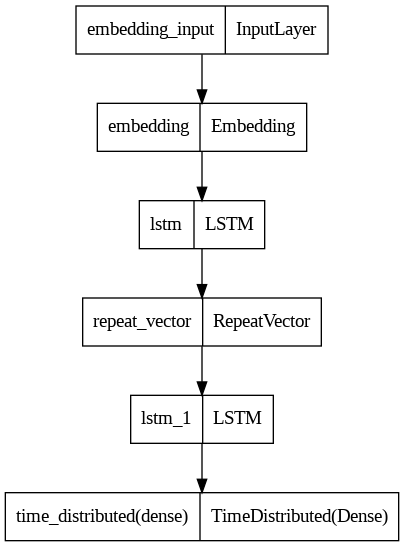

In [ ]:
import keras
from keras.utils import plot_model
plot_model(model_trans)

# Model testing

In [ ]:
def word_for_id(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index == integer:
      print("I am word",word)
      return word
  return None

In [ ]:
# generate target given sequence
def predict_sequence(model,tokenizer,source):
  prediction = model.predict(source,verbose=0)[0]
  print(prediction)
  integers = [np.argmax(vector) for vector in prediction]
  print(integers)
  target = list()
  for i in integers:
    word = word_for_id(i,tokenizer)
    if word is None:
      break
    target.append(word)
  print(target)
  return " ".join(target)

In [ ]:
# evaluate the skill of all the model
def evaluate_model(model, bhoj_tokenizer,sources, english_sentences,bhojpuri_sentences):
  actual,predicted = list(),list()
  for i,source in enumerate(sources):
    # translate encoded source text
    source = source.reshape((1,source.shape[0]))
    translation = predict_sequence(model,bhoj_tokenizer,source)
    raw_target, raw_src = bhojpuri_sentences[i], english_sentences[i]
    if i < 10:
      print('src=[%s], target=[%s], predicted=[%s]' % (raw_src,raw_target,translation))
    actual.append(raw_target.split())
    predicted.append(translation.split())
  # calculate the BLEU score
  #print('BLEU-1 : %f' % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))

In [ ]:
evaluate_model(model_trans,bhoj_tokenizer,trainX[0:5],english_sentences,bhojpuri_sentences)

[[1.7936883e-03 2.1409320e-03 1.4247838e-03 ... 8.5719839e-05
  9.0644542e-05 9.6509233e-05]
 [2.7196942e-02 1.5433234e-02 6.8318420e-03 ... 2.0874475e-05
  2.4663388e-05 2.6876380e-05]
 [4.6944880e-01 1.9274896e-02 6.7502637e-03 ... 2.9136770e-06
  3.9206761e-06 4.2677661e-06]
 ...
 [9.7633034e-01 1.0069257e-03 3.0025060e-04 ... 3.0371105e-08
  4.8024951e-08 5.0593052e-08]
 [9.7633034e-01 1.0069257e-03 3.0025060e-04 ... 3.0371105e-08
  4.8024951e-08 5.0593052e-08]
 [9.7633034e-01 1.0069257e-03 3.0025060e-04 ... 3.0371105e-08
  4.8024951e-08 5.0593052e-08]]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
I am word के
['के']
src=[How are you?], target=[का हाल बा?], predicted=[के]
[[2.5643236e-03 3.5923123e-03 2.1599855e-03 ... 6.6331966e-05
  7.1091752e-05 7.6323187e-05]
 [3.6257297e-02 2.5602356e-02 1.0078262e-02 ... 1.4093757e-05
  1.6953769e-05 1.8498511e-05]
 [4.5705071